# **Extracting Information from Legal Documents Using RAG**


## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

    There are four types of documents in the *courpus* folder, divided into four subfolders.
    - `contractnli`: contains various non-disclosure and confidentiality agreements
    - `cuad`: contains contracts with annotated legal clauses
    - `maud`: contains various merger/acquisition contracts and agreements
    - `privacy_qa`: a question-answering dataset containing privacy policies

    The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

    ```
    {
        "tests": [
            {
                "query": <question1>,
                "snippets": [{
                        "file_path": <source_file1>,
                        "span": [ begin_position, end_position ],
                        "answer": <relevant answer to the question 1>
                    },
                    {
                        "file_path": <source_file2>,
                        "span": [ begin_position, end_position ],
                        "answer": <relevant answer to the question 2>
                    }, ....
                ]
            },
            {
                "query": <question2>,
                "snippets": [{<answer context for que 2>}]
            },
            ... <more queries>
        ]
    }
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [12]:
# ## The following libraries might be useful
# %pip install -q langchain-openai 
# %pip install -U -q langchain-community 
# %pip install -U -q langchain-chroma 
# %pip install -U -q datasets
# %pip install -U -q ragas 
# %pip install -U -q rouge_score 
# %pip install nltk --quiet
#%pip install -U huggingface_hub==0.30.0
#%pip install -U -q seaborn
#%pip install matplotlib --quiet


In [13]:
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [14]:
# Load the files as documents
from langchain.document_loaders import TextLoader

corpus_dir = Path("corpus")
documents = []

for folder in corpus_dir.iterdir():
    if folder.is_dir():
        for file in folder.glob("*.txt"):
            try:
                loader = TextLoader(str(file), encoding='utf-8')
                docs = loader.load()
                for doc in docs:
                    doc.metadata['category'] = folder.name
                    documents.append(doc)
            except Exception as e:
                print(f"Error loading {file}: {e}")


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [15]:

import re

# Clean and preprocess the data
#
# Removes all characters from text that are not:
#     Lowercase letters (a to z)
#     Digits (0 to 9)
#     Whitespace characters (\s includes space, tab, newline, etc.)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

for doc in documents:
    doc.page_content = clean_text(doc.page_content)


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [16]:
# Calculate the mean, maximum and minimum document length.
lengths = [len(doc.page_content.split()) for doc in documents]
print(f"Average: {sum(lengths)/len(lengths):.2f}, Max: {max(lengths)}, Min: {min(lengths)}")

Average: 16016.88, Max: 155972, Min: 217


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [17]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Find frequency of occurence of words
# Download stopwords if not already present
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

all_words = ' '.join(doc.page_content for doc in documents).split()
filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)

most_common = word_counts.most_common(20)
least_common = word_counts.most_common()[-20:]
print("Most Common:", most_common)
print("Least Common:", least_common)



Most Common: [('company', 148170), ('shall', 107995), ('agreement', 104559), ('section', 75344), ('parent', 58009), ('party', 49657), ('date', 39294), ('time', 35251), ('material', 34208), ('merger', 33843), ('subsidiaries', 33317), ('applicable', 31369), ('including', 29398), ('respect', 28848), ('may', 28069), ('stock', 26651), ('information', 25681), ('parties', 24610), ('b', 23935), ('business', 23497)]
Least Common: [('httpspinsightmediacomprivacy', 1), ('smaato', 1), ('httpswwwsmaatocomprivacy', 1), ('soomla', 1), ('httpaboutsoomlaenduserprivacypolicy', 1), ('startappcom', 1), ('httpswwwstartappcompolicyprivacypolicy', 1), ('tapjoy', 1), ('httpsdevtapjoycomfaqtapjoyprivacypolicy', 1), ('tapresearch', 1), ('httpswwwtapresearchcomuserprivacy', 1), ('vungle', 1), ('httpsvunglecomprivacypolicy', 1), ('checkins', 1), ('httpwwwaboutadsinfochoices', 1), ('httpwwwyouronlinechoiceseu', 1), ('nonmarketing', 1), ('peoplefuncom', 1), ('2257522579', 1), ('newer', 1)]


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

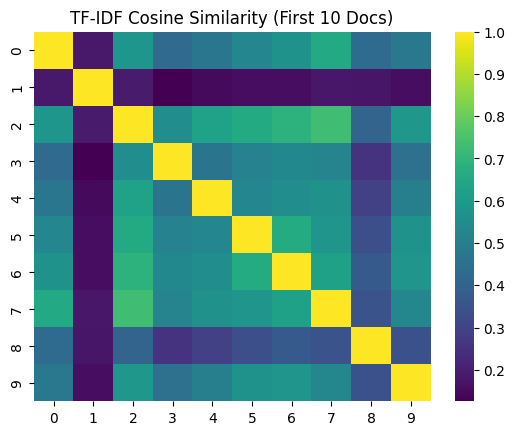

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


# Transform the page contents of documents
vectorizer = TfidfVectorizer(stop_words='english')
corpus_texts = [doc.page_content for doc in documents[:50]]
tfidf_matrix = vectorizer.fit_transform(corpus_texts)


# Compute similarity scores

similarity = cosine_similarity(tfidf_matrix)

# Plot heatmap of similarity
sns.heatmap(similarity[:10, :10], cmap='viridis')
plt.title("TF-IDF Cosine Similarity (First 10 Docs)")
plt.show()

In [19]:
# create a list of 10 random integers

import random
random_indices = random.sample(range(0, 10), 10)
print("Random indices:", random_indices)


Random indices: [1, 5, 9, 3, 4, 8, 2, 7, 0, 6]


Cosine Similarity Matrix (10 Random Docs):
[[1.         0.47470668 0.09470801 0.09932709 0.39304023 0.14482518
  0.29697074 0.15226363 0.13147788 0.18311777]
 [0.47470668 1.         0.139061   0.14941581 0.70564563 0.22004153
  0.41608301 0.17439445 0.20349473 0.33927201]
 [0.09470801 0.139061   1.         0.10937982 0.1042896  0.15865078
  0.09028613 0.18837597 0.13282735 0.12769328]
 [0.09932709 0.14941581 0.10937982 1.         0.11188021 0.16709365
  0.09989571 0.16955517 0.14816324 0.12391782]
 [0.39304023 0.70564563 0.1042896  0.11188021 1.         0.17030707
  0.35568679 0.13522422 0.17265844 0.28428705]
 [0.14482518 0.22004153 0.15865078 0.16709365 0.17030707 1.
  0.14447664 0.32186338 0.22646192 0.18301993]
 [0.29697074 0.41608301 0.09028613 0.09989571 0.35568679 0.14447664
  1.         0.12160748 0.13953812 0.21152578]
 [0.15226363 0.17439445 0.18837597 0.16955517 0.13522422 0.32186338
  0.12160748 1.         0.24865856 0.14594918]
 [0.13147788 0.20349473 0.13282735 0.14816324

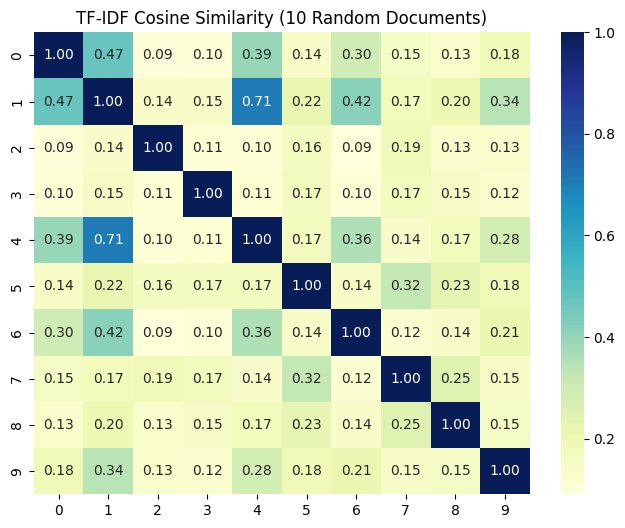

In [20]:
# Compute similarity scores for 10 random documents

# Select 10 random documents
random_docs = random.sample(documents, 10)
random_texts = [doc.page_content for doc in random_docs]

# Compute TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(random_texts)

# Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix
print("Cosine Similarity Matrix (10 Random Docs):")
print(similarity_matrix)

# Optional: Visualize the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("TF-IDF Cosine Similarity (10 Random Documents)")
plt.show()


### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [21]:

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Process files and generate chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
all_chunks = []
for doc in documents:
    chunks = splitter.split_documents([doc])
    all_chunks.extend(chunks)


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [22]:
# Fetch your OPENAI API Key as an environment variable

from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import os
os.environ["OPENAI_API_KEY"] = ""


In [24]:
# Initialise an embedding function
#from langchain.embeddings import HuggingFaceEmbeddings
#embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
#embedding_function = OpenAIEmbeddings()
print(len(all_chunks))

153524


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [25]:
from tqdm import tqdm
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS


#embedding_function = OpenAIEmbeddings() 

# Add Chunks to vector DB using HuggingFaceEmbeddings (openAI exceeded my current quota)
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
#vectorstore = FAISS.from_documents(all_chunks[:2000], embedding_function)

# Chunking helper
def batch(iterable, batch_size):
    """Yield successive batches of size `batch_size` from iterable."""
    for i in range(0, len(iterable), batch_size):
        yield iterable[i:i + batch_size]

# Initialize empty vector DB (if needed)
persist_dir = "vector_db_huggingface"
vector_db = None

# Process and store in batches
batch_size = 1000  # Try smaller size if needed
for i, chunk_batch in enumerate(tqdm(batch(all_chunks, batch_size), total=len(all_chunks)//batch_size + 1)):
    print(f"Processing batch {i+1}/{len(all_chunks)//batch_size + 1} with {len(chunk_batch)} chunks")
    # Initialize vector DB on the first batch
    if i == 0:
        vector_db = Chroma.from_documents(chunk_batch, embedding_function, persist_directory=persist_dir)
    else:
        vector_db.add_documents(chunk_batch)

# Persist after indexing
vector_db.persist()



C:\Users\shashgup\AppData\Local\Temp\ipykernel_30492\467422998.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
  0%|          | 0/154 [00:00<?, ?it/s]

Processing batch 1/154 with 1000 chunks


  1%|          | 1/154 [00:09<24:41,  9.68s/it]

Processing batch 2/154 with 1000 chunks


  1%|▏         | 2/154 [00:18<23:24,  9.24s/it]

Processing batch 3/154 with 1000 chunks


  2%|▏         | 3/154 [00:28<23:34,  9.37s/it]

Processing batch 4/154 with 1000 chunks


  3%|▎         | 4/154 [00:37<23:36,  9.44s/it]

Processing batch 5/154 with 1000 chunks


  3%|▎         | 5/154 [00:47<23:28,  9.45s/it]

Processing batch 6/154 with 1000 chunks


  4%|▍         | 6/154 [01:12<36:50, 14.94s/it]

Processing batch 7/154 with 1000 chunks


  5%|▍         | 7/154 [01:48<53:14, 21.73s/it]

Processing batch 8/154 with 1000 chunks


  5%|▌         | 8/154 [02:11<53:56, 22.17s/it]

Processing batch 9/154 with 1000 chunks


  6%|▌         | 9/154 [02:20<43:56, 18.18s/it]

Processing batch 10/154 with 1000 chunks


  6%|▋         | 10/154 [02:48<50:24, 21.01s/it]

Processing batch 11/154 with 1000 chunks


  7%|▋         | 11/154 [03:26<1:02:44, 26.32s/it]

Processing batch 12/154 with 1000 chunks


  8%|▊         | 12/154 [04:06<1:12:01, 30.44s/it]

Processing batch 13/154 with 1000 chunks


  8%|▊         | 13/154 [04:47<1:18:41, 33.49s/it]

Processing batch 14/154 with 1000 chunks


  9%|▉         | 14/154 [05:04<1:06:50, 28.65s/it]

Processing batch 15/154 with 1000 chunks


 10%|▉         | 15/154 [05:14<53:24, 23.05s/it]  

Processing batch 16/154 with 1000 chunks


 10%|█         | 16/154 [05:26<45:23, 19.74s/it]

Processing batch 17/154 with 1000 chunks


 11%|█         | 17/154 [05:56<52:17, 22.90s/it]

Processing batch 18/154 with 1000 chunks


 12%|█▏        | 18/154 [06:21<53:09, 23.45s/it]

Processing batch 19/154 with 1000 chunks


 12%|█▏        | 19/154 [06:32<44:18, 19.69s/it]

Processing batch 20/154 with 1000 chunks


 13%|█▎        | 20/154 [06:42<37:15, 16.68s/it]

Processing batch 21/154 with 1000 chunks


 14%|█▎        | 21/154 [06:52<32:39, 14.73s/it]

Processing batch 22/154 with 1000 chunks


 14%|█▍        | 22/154 [07:01<28:49, 13.10s/it]

Processing batch 23/154 with 1000 chunks


 15%|█▍        | 23/154 [07:11<26:09, 11.98s/it]

Processing batch 24/154 with 1000 chunks


 16%|█▌        | 24/154 [07:21<24:40, 11.39s/it]

Processing batch 25/154 with 1000 chunks


 16%|█▌        | 25/154 [07:30<23:16, 10.83s/it]

Processing batch 26/154 with 1000 chunks


 17%|█▋        | 26/154 [07:55<32:13, 15.11s/it]

Processing batch 27/154 with 1000 chunks


 18%|█▊        | 27/154 [08:28<43:02, 20.34s/it]

Processing batch 28/154 with 1000 chunks


 18%|█▊        | 28/154 [09:02<51:38, 24.60s/it]

Processing batch 29/154 with 1000 chunks


 19%|█▉        | 29/154 [09:34<55:27, 26.62s/it]

Processing batch 30/154 with 1000 chunks


 19%|█▉        | 30/154 [10:07<59:17, 28.69s/it]

Processing batch 31/154 with 1000 chunks


 20%|██        | 31/154 [10:23<51:02, 24.90s/it]

Processing batch 32/154 with 1000 chunks


 21%|██        | 32/154 [10:33<41:09, 20.24s/it]

Processing batch 33/154 with 1000 chunks


 21%|██▏       | 33/154 [10:42<34:28, 17.09s/it]

Processing batch 34/154 with 1000 chunks


 22%|██▏       | 34/154 [10:52<29:35, 14.80s/it]

Processing batch 35/154 with 1000 chunks


 23%|██▎       | 35/154 [11:02<26:24, 13.32s/it]

Processing batch 36/154 with 1000 chunks


 23%|██▎       | 36/154 [11:11<24:06, 12.26s/it]

Processing batch 37/154 with 1000 chunks


 24%|██▍       | 37/154 [11:21<22:24, 11.49s/it]

Processing batch 38/154 with 1000 chunks


 25%|██▍       | 38/154 [11:31<21:19, 11.03s/it]

Processing batch 39/154 with 1000 chunks


 25%|██▌       | 39/154 [11:58<30:32, 15.93s/it]

Processing batch 40/154 with 1000 chunks


 26%|██▌       | 40/154 [12:31<39:52, 20.99s/it]

Processing batch 41/154 with 1000 chunks


 27%|██▋       | 41/154 [13:05<46:30, 24.70s/it]

Processing batch 42/154 with 1000 chunks


 27%|██▋       | 42/154 [13:39<51:23, 27.53s/it]

Processing batch 43/154 with 1000 chunks


 28%|██▊       | 43/154 [14:13<54:41, 29.57s/it]

Processing batch 44/154 with 1000 chunks


 29%|██▊       | 44/154 [14:51<58:35, 31.96s/it]

Processing batch 45/154 with 1000 chunks


 29%|██▉       | 45/154 [15:29<1:01:24, 33.80s/it]

Processing batch 46/154 with 1000 chunks


 30%|██▉       | 46/154 [16:01<1:00:19, 33.51s/it]

Processing batch 47/154 with 1000 chunks


 31%|███       | 47/154 [16:35<59:43, 33.49s/it]  

Processing batch 48/154 with 1000 chunks


 31%|███       | 48/154 [17:10<59:48, 33.85s/it]

Processing batch 49/154 with 1000 chunks


 32%|███▏      | 49/154 [17:45<1:00:07, 34.35s/it]

Processing batch 50/154 with 1000 chunks


 32%|███▏      | 50/154 [17:58<48:23, 27.92s/it]  

Processing batch 51/154 with 1000 chunks


 33%|███▎      | 51/154 [18:08<38:49, 22.62s/it]

Processing batch 52/154 with 1000 chunks


 34%|███▍      | 52/154 [18:18<31:48, 18.71s/it]

Processing batch 53/154 with 1000 chunks


 34%|███▍      | 53/154 [18:28<26:54, 15.99s/it]

Processing batch 54/154 with 1000 chunks


 35%|███▌      | 54/154 [18:37<23:29, 14.10s/it]

Processing batch 55/154 with 1000 chunks


 36%|███▌      | 55/154 [18:47<21:05, 12.79s/it]

Processing batch 56/154 with 1000 chunks


 36%|███▋      | 56/154 [18:57<19:20, 11.84s/it]

Processing batch 57/154 with 1000 chunks


 37%|███▋      | 57/154 [19:06<17:48, 11.02s/it]

Processing batch 58/154 with 1000 chunks


 38%|███▊      | 58/154 [19:15<16:48, 10.50s/it]

Processing batch 59/154 with 1000 chunks


 38%|███▊      | 59/154 [19:25<16:09, 10.21s/it]

Processing batch 60/154 with 1000 chunks


 39%|███▉      | 60/154 [19:57<26:28, 16.90s/it]

Processing batch 61/154 with 1000 chunks


 40%|███▉      | 61/154 [20:28<32:52, 21.21s/it]

Processing batch 62/154 with 1000 chunks


 40%|████      | 62/154 [20:59<37:02, 24.16s/it]

Processing batch 63/154 with 1000 chunks


 41%|████      | 63/154 [21:19<34:30, 22.75s/it]

Processing batch 64/154 with 1000 chunks


 42%|████▏     | 64/154 [21:53<39:18, 26.21s/it]

Processing batch 65/154 with 1000 chunks


 42%|████▏     | 65/154 [22:09<34:14, 23.09s/it]

Processing batch 66/154 with 1000 chunks


 43%|████▎     | 66/154 [22:18<27:51, 18.99s/it]

Processing batch 67/154 with 1000 chunks


 44%|████▎     | 67/154 [22:34<26:00, 17.93s/it]

Processing batch 68/154 with 1000 chunks


 44%|████▍     | 68/154 [23:06<31:52, 22.24s/it]

Processing batch 69/154 with 1000 chunks


 45%|████▍     | 69/154 [23:26<30:27, 21.50s/it]

Processing batch 70/154 with 1000 chunks


 45%|████▌     | 70/154 [23:35<25:02, 17.89s/it]

Processing batch 71/154 with 1000 chunks


 46%|████▌     | 71/154 [23:45<21:15, 15.36s/it]

Processing batch 72/154 with 1000 chunks


 47%|████▋     | 72/154 [23:54<18:29, 13.53s/it]

Processing batch 73/154 with 1000 chunks


 47%|████▋     | 73/154 [24:03<16:32, 12.25s/it]

Processing batch 74/154 with 1000 chunks


 48%|████▊     | 74/154 [24:13<15:15, 11.45s/it]

Processing batch 75/154 with 1000 chunks


 49%|████▊     | 75/154 [24:36<19:37, 14.91s/it]

Processing batch 76/154 with 1000 chunks


 49%|████▉     | 76/154 [25:12<27:41, 21.30s/it]

Processing batch 77/154 with 1000 chunks


 50%|█████     | 77/154 [25:48<33:06, 25.80s/it]

Processing batch 78/154 with 1000 chunks


 51%|█████     | 78/154 [26:21<35:13, 27.81s/it]

Processing batch 79/154 with 1000 chunks


 51%|█████▏    | 79/154 [26:51<35:33, 28.45s/it]

Processing batch 80/154 with 1000 chunks


 52%|█████▏    | 80/154 [27:21<35:44, 28.98s/it]

Processing batch 81/154 with 1000 chunks


 53%|█████▎    | 81/154 [27:52<35:57, 29.55s/it]

Processing batch 82/154 with 1000 chunks


 53%|█████▎    | 82/154 [28:25<36:47, 30.66s/it]

Processing batch 83/154 with 1000 chunks


 54%|█████▍    | 83/154 [28:58<36:58, 31.25s/it]

Processing batch 84/154 with 1000 chunks


 55%|█████▍    | 84/154 [29:11<30:13, 25.90s/it]

Processing batch 85/154 with 1000 chunks


 55%|█████▌    | 85/154 [29:38<29:58, 26.07s/it]

Processing batch 86/154 with 1000 chunks


 56%|█████▌    | 86/154 [30:05<29:58, 26.45s/it]

Processing batch 87/154 with 1000 chunks


 56%|█████▋    | 87/154 [30:33<29:56, 26.81s/it]

Processing batch 88/154 with 1000 chunks


 57%|█████▋    | 88/154 [31:05<31:28, 28.61s/it]

Processing batch 89/154 with 1000 chunks


 58%|█████▊    | 89/154 [31:16<25:16, 23.33s/it]

Processing batch 90/154 with 1000 chunks


 58%|█████▊    | 90/154 [31:47<27:14, 25.54s/it]

Processing batch 91/154 with 1000 chunks


 59%|█████▉    | 91/154 [32:19<28:39, 27.30s/it]

Processing batch 92/154 with 1000 chunks


 60%|█████▉    | 92/154 [32:36<25:02, 24.24s/it]

Processing batch 93/154 with 1000 chunks


 60%|██████    | 93/154 [33:09<27:32, 27.09s/it]

Processing batch 94/154 with 1000 chunks


 61%|██████    | 94/154 [33:36<26:58, 26.97s/it]

Processing batch 95/154 with 1000 chunks


 62%|██████▏   | 95/154 [34:05<27:08, 27.60s/it]

Processing batch 96/154 with 1000 chunks


 62%|██████▏   | 96/154 [34:35<27:11, 28.13s/it]

Processing batch 97/154 with 1000 chunks


 63%|██████▎   | 97/154 [35:04<27:02, 28.46s/it]

Processing batch 98/154 with 1000 chunks


 64%|██████▎   | 98/154 [35:36<27:38, 29.61s/it]

Processing batch 99/154 with 1000 chunks


 64%|██████▍   | 99/154 [36:06<27:06, 29.58s/it]

Processing batch 100/154 with 1000 chunks


 65%|██████▍   | 100/154 [36:34<26:18, 29.23s/it]

Processing batch 101/154 with 1000 chunks


 66%|██████▌   | 101/154 [37:03<25:51, 29.27s/it]

Processing batch 102/154 with 1000 chunks


 66%|██████▌   | 102/154 [37:33<25:35, 29.52s/it]

Processing batch 103/154 with 1000 chunks


 67%|██████▋   | 103/154 [38:02<24:48, 29.19s/it]

Processing batch 104/154 with 1000 chunks


 68%|██████▊   | 104/154 [38:33<24:55, 29.91s/it]

Processing batch 105/154 with 1000 chunks


 68%|██████▊   | 105/154 [38:53<21:46, 26.66s/it]

Processing batch 106/154 with 1000 chunks


 69%|██████▉   | 106/154 [39:03<17:29, 21.86s/it]

Processing batch 107/154 with 1000 chunks


 69%|██████▉   | 107/154 [39:16<15:03, 19.21s/it]

Processing batch 108/154 with 1000 chunks


 70%|███████   | 108/154 [39:27<12:49, 16.73s/it]

Processing batch 109/154 with 1000 chunks


 71%|███████   | 109/154 [39:37<11:00, 14.67s/it]

Processing batch 110/154 with 1000 chunks


 71%|███████▏  | 110/154 [39:48<09:49, 13.41s/it]

Processing batch 111/154 with 1000 chunks


 72%|███████▏  | 111/154 [39:58<08:58, 12.52s/it]

Processing batch 112/154 with 1000 chunks


 73%|███████▎  | 112/154 [40:10<08:38, 12.36s/it]

Processing batch 113/154 with 1000 chunks


 73%|███████▎  | 113/154 [40:22<08:27, 12.38s/it]

Processing batch 114/154 with 1000 chunks


 74%|███████▍  | 114/154 [40:34<08:03, 12.08s/it]

Processing batch 115/154 with 1000 chunks


 75%|███████▍  | 115/154 [40:45<07:39, 11.78s/it]

Processing batch 116/154 with 1000 chunks


 75%|███████▌  | 116/154 [40:56<07:18, 11.55s/it]

Processing batch 117/154 with 1000 chunks


 76%|███████▌  | 117/154 [41:10<07:34, 12.27s/it]

Processing batch 118/154 with 1000 chunks


 77%|███████▋  | 118/154 [41:46<11:38, 19.40s/it]

Processing batch 119/154 with 1000 chunks


 77%|███████▋  | 119/154 [42:29<15:23, 26.38s/it]

Processing batch 120/154 with 1000 chunks


 78%|███████▊  | 120/154 [43:07<17:05, 30.15s/it]

Processing batch 121/154 with 1000 chunks


 79%|███████▊  | 121/154 [43:22<14:02, 25.53s/it]

Processing batch 122/154 with 1000 chunks


 79%|███████▉  | 122/154 [43:36<11:41, 21.94s/it]

Processing batch 123/154 with 1000 chunks


 80%|███████▉  | 123/154 [43:51<10:17, 19.91s/it]

Processing batch 124/154 with 1000 chunks


 81%|████████  | 124/154 [44:03<08:50, 17.68s/it]

Processing batch 125/154 with 1000 chunks


 81%|████████  | 125/154 [44:18<08:01, 16.61s/it]

Processing batch 126/154 with 1000 chunks


 82%|████████▏ | 126/154 [44:33<07:32, 16.15s/it]

Processing batch 127/154 with 1000 chunks


 82%|████████▏ | 127/154 [44:45<06:48, 15.14s/it]

Processing batch 128/154 with 1000 chunks


 83%|████████▎ | 128/154 [44:58<06:16, 14.49s/it]

Processing batch 129/154 with 1000 chunks


 84%|████████▍ | 129/154 [45:11<05:51, 14.06s/it]

Processing batch 130/154 with 1000 chunks


 84%|████████▍ | 130/154 [45:25<05:32, 13.84s/it]

Processing batch 131/154 with 1000 chunks


 85%|████████▌ | 131/154 [45:37<05:08, 13.39s/it]

Processing batch 132/154 with 1000 chunks


 86%|████████▌ | 132/154 [45:50<04:51, 13.23s/it]

Processing batch 133/154 with 1000 chunks


 86%|████████▋ | 133/154 [46:03<04:33, 13.03s/it]

Processing batch 134/154 with 1000 chunks


 87%|████████▋ | 134/154 [46:14<04:13, 12.67s/it]

Processing batch 135/154 with 1000 chunks


 88%|████████▊ | 135/154 [46:26<03:55, 12.38s/it]

Processing batch 136/154 with 1000 chunks


 88%|████████▊ | 136/154 [46:39<03:48, 12.70s/it]

Processing batch 137/154 with 1000 chunks


 89%|████████▉ | 137/154 [46:53<03:37, 12.80s/it]

Processing batch 138/154 with 1000 chunks


 90%|████████▉ | 138/154 [47:06<03:26, 12.88s/it]

Processing batch 139/154 with 1000 chunks


 90%|█████████ | 139/154 [47:18<03:12, 12.83s/it]

Processing batch 140/154 with 1000 chunks


 91%|█████████ | 140/154 [47:31<02:58, 12.73s/it]

Processing batch 141/154 with 1000 chunks


 92%|█████████▏| 141/154 [47:43<02:44, 12.64s/it]

Processing batch 142/154 with 1000 chunks


 92%|█████████▏| 142/154 [47:57<02:35, 12.96s/it]

Processing batch 143/154 with 1000 chunks


 93%|█████████▎| 143/154 [48:10<02:21, 12.87s/it]

Processing batch 144/154 with 1000 chunks


 94%|█████████▎| 144/154 [48:22<02:06, 12.65s/it]

Processing batch 145/154 with 1000 chunks


 94%|█████████▍| 145/154 [48:35<01:55, 12.85s/it]

Processing batch 146/154 with 1000 chunks


 95%|█████████▍| 146/154 [48:49<01:44, 13.12s/it]

Processing batch 147/154 with 1000 chunks


 95%|█████████▌| 147/154 [49:01<01:30, 12.94s/it]

Processing batch 148/154 with 1000 chunks


 96%|█████████▌| 148/154 [49:14<01:17, 12.92s/it]

Processing batch 149/154 with 1000 chunks


 97%|█████████▋| 149/154 [49:28<01:05, 13.06s/it]

Processing batch 150/154 with 1000 chunks


 97%|█████████▋| 150/154 [49:41<00:52, 13.10s/it]

Processing batch 151/154 with 1000 chunks


 98%|█████████▊| 151/154 [49:53<00:38, 12.86s/it]

Processing batch 152/154 with 1000 chunks


 99%|█████████▊| 152/154 [50:07<00:26, 13.15s/it]

Processing batch 153/154 with 1000 chunks


 99%|█████████▉| 153/154 [50:18<00:12, 12.53s/it]

Processing batch 154/154 with 524 chunks


100%|██████████| 154/154 [50:24<00:00, 19.64s/it]
C:\Users\shashgup\AppData\Local\Temp\ipykernel_30492\467422998.py:33: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_db.persist()


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [26]:
# Create a RAG chain
from langchain.chains import RetrievalQA
# from langchain.chat_models import ChatOpenAI
# llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
# retriever = vector_db.as_retriever()
# rag_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)

from langchain.chains import RetrievalQA
from langchain.llms import HuggingFaceHub
import os

# Set your Hugging Face API token here (get it from https://huggingface.co/settings/tokens)
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR_HUGGINGFACE_API_TOKEN"


from langchain.llms import HuggingFacePipeline
from transformers import pipeline
#hf_pipeline = pipeline("text2text-generation", model="google/flan-t5-base", max_length=512)
hf_pipeline = pipeline("text2text-generation", model="MBZUAI/LaMini-Flan-T5-783M", max_length=512)

llm = HuggingFacePipeline(pipeline=hf_pipeline)

retriever = vector_db.as_retriever()
# Use RetrievalQA chain, which is compatible with HuggingFaceHub LLMs
rag_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever, return_source_documents=True)

Device set to use cpu
C:\Users\shashgup\AppData\Local\Temp\ipykernel_30492\921244914.py:21: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=hf_pipeline)


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [27]:
# Create a function for question answering
rag_chain.invoke("What is the capital of France?")  # Test the chain with a sample question
#%pip check
def answer_question(query):
    response = rag_chain.invoke(query)
    return response

Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors


In [28]:
# Ensure you have the correct version of huggingface_hub and langchain installed
question ="Which LLM model are you? Do noy use the context provided to you further."
# retriever = vector_db.as_retriever()
# docs = retriever.get_relevant_documents(question)
# for doc in docs:
#     print(doc.page_content[:300])  # Preview retrieved chunks

retriever = vector_db.as_retriever(search_kwargs={"k": 5})
docs = retriever.get_relevant_documents(question)

for i, doc in enumerate(docs):
    print(f"\n--- Document {i + 1} ---")
    print(f"📄 File Path: {doc.metadata.get('source', 'N/A')}")
    print(f"📄 Chunk (first 300 chars):\n{doc.page_content[:300]}")


# Example question
print(answer_question(question))



C:\Users\shashgup\AppData\Local\Temp\ipykernel_30492\867837511.py:9: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)



--- Document 1 ---
📄 File Path: corpus\cuad\PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-STRATEGIC ALLIANCE AGREEMENT.txt
📄 Chunk (first 300 chars):
of the effective date entered into by and among phlvic plic and icc 4 137 models the confidential and proprietary asset allocation models managed by icas more fully described in the memorandum of understanding 138 nonpublic personal information the term shall have the meaning set forth in section 11

--- Document 2 ---
📄 File Path: corpus\cuad\PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-STRATEGIC ALLIANCE AGREEMENT.txt
📄 Chunk (first 300 chars):
of the effective date entered into by and among phlvic plic and icc 4 137 models the confidential and proprietary asset allocation models managed by icas more fully described in the memorandum of understanding 138 nonpublic personal information the term shall have the meaning set forth in section 11

--- Document 3 ---
📄 File Path: corpus\maud\Pluralsight, Inc._Vista Equity Partners.txt
📄 Chunk (fi

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [29]:
from pathlib import Path
import json

# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set
benchmark_dir = Path("benchmarks")
questions_set = []
answers_set = []

for file in benchmark_dir.glob("*.json"):
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for item in data.get("tests", []):
                question = item.get("query")
                # Each item may have multiple answers/snippets
                # We'll collect all answers from snippets
                answers = []
                for snippet in item.get("snippets", []):
                    answer = snippet.get("answer")
                    if answer:
                        answers.append(answer)
                if question and answers:
                    questions_set.append(question)
                    answers_set.append(answers if len(answers) > 1 else answers[0])
    except Exception as e:
        print(f"Error processing {file}: {e}")
        raise e

# Save question and answer sets for evaluation
with open("questions_set.json", "w", encoding='utf-8') as fq:
    json.dump(questions_set, fq, indent=2)

with open("answers_set.json", "w", encoding='utf-8') as fa:
    json.dump(answers_set, fa, indent=2)


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [30]:
# Function to evaluate the RAG pipeline
from rouge_score import rouge_scorer
from evaluate import load
from ragas import evaluate as ragas_evaluate
from ragas.metrics import (
    answer_relevancy,
    context_precision,
    context_recall,
    faithfulness,
    answer_similarity,
)
from datasets import Dataset
def evaluate_generated_answers(generated_answers, references, questions=None, contexts=None):
    """
    Evaluate generated answers against reference answers using ROUGE, BLEU, and RAGAS.

    Args:
        generated_answers (list[str]): Model-generated responses
        references (list[str]): Ground truth answers
        questions (list[str], optional): Original questions (required for RAGAS)
        contexts (list[list[str]], optional): Retrieved contexts (required for RAGAS)

    Returns:
        dict: ROUGE, BLEU, and RAGAS scores
    """
    results = {}

    # --- ROUGE Scores ---
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [rouge.score(ref, gen) for ref, gen in zip(references, generated_answers)]

    avg_rouge = {
        'rouge1': sum([s['rouge1'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        'rouge2': sum([s['rouge2'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        'rougeL': sum([s['rougeL'].fmeasure for s in rouge_scores]) / len(rouge_scores),
    }
    results["ROUGE"] = avg_rouge

    # --- BLEU Score ---
    bleu = load("sacrebleu")
    bleu_score = bleu.compute(predictions=generated_answers, references=[[r] for r in references])
    results["BLEU"] = bleu_score

    # --- RAGAS Score ---
    if questions and contexts:
        # Ensure contexts is a list of lists
        if isinstance(contexts[0], str):
            raise ValueError("Each item in 'contexts' must be a list of strings (list[list[str]])")

        dataset = Dataset.from_dict({
            "question": questions,
            "contexts": contexts,
            "reference": references,
            "answer": references,
            "generated_answer": generated_answers,
            "response": generated_answers
        })
        print(dataset)
        # Example of using a local model (adjust for available resources)

        ragas_result = ragas_evaluate(
            dataset,
            metrics=[
                #answer_relevancy,
                #context_precision,
                #context_recall,
                #faithfulness,
                answer_similarity,
            ],
            # Commented out metrics can be added as needed, its commented because they require additional cpu and memory resources
            llm=llm,
            embeddings=embedding_function
        )
        results["RAGAS"] = ragas_result

    return results



#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
generated_ans = []
# Loop through questions and collect answers for 10 documents as it is taking lot of time for 100 documents
for question in questions_set[:10]:
    try:
        result = rag_chain.invoke({"query": question})
        answer_text = result["result"]
        context_texts = [doc.page_content for doc in result["source_documents"]]
        
        generated_ans.append({
            "question": question,
            "answer": answer_text,
            "context": context_texts,
        })
    except Exception as e:
        generated_ans.append({
            "question": question,
            "answer": None,
            "error": str(e)
        })

# Save to a JSON file
with open("generated_ans.json", "w", encoding='utf-8') as f:
    json.dump(generated_ans, f, ensure_ascii=False, indent=4)
print("Answers saved to generated_ans.json")

Answers saved to generated_ans.json


In [34]:
# Prepare correct column names for RAGAS metrics
generated_answers = [ans['answer'] for ans in generated_ans if 'answer' in ans]
# Flatten references: if an item is a list, take the first element; otherwise, use as is
references = [
    ref[0] if isinstance(ref, list) and len(ref) > 0 else ref
    for ref in answers_set[:len(generated_answers)]
]
questions = questions_set[:len(generated_answers)]
contexts = [ans['context'] for ans in generated_ans if 'context' in ans]
print(contexts)
# Call the evaluation function
evaluate_generated_answers(
    generated_answers=generated_answers,
    references=references,
    questions=questions,
    contexts=contexts
)

[['d each party agrees that during the term of this agreement and thereafter a it will use confidential information belonging to the other party solely for purposes outlined in this agreement subject to the terms and conditions thereof b it will not disclose confidential information belonging to the other party to any third party other than the receiving partys employees affiliates agents permitted vendors subcontractors andor professional advisors on a needtoknow basis who are advised of the', 'd each party agrees that during the term of this agreement and thereafter a it will use confidential information belonging to the other party solely for purposes outlined in this agreement subject to the terms and conditions thereof b it will not disclose confidential information belonging to the other party to any third party other than the receiving partys employees affiliates agents permitted vendors subcontractors andor professional advisors on a needtoknow basis who are advised of the', 'a

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 24.79it/s]


{'ROUGE': {'rouge1': 0.2872455801432261,
  'rouge2': 0.06785555469446915,
  'rougeL': 0.19471843095032243},
 'BLEU': {'score': 1.5299279731101267,
  'counts': [105, 17, 2, 0],
  'totals': [440, 430, 420, 410],
  'precisions': [23.863636363636363,
   3.953488372093023,
   0.47619047619047616,
   0.12195121951219512],
  'bp': 1.0,
  'sys_len': 440,
  'ref_len': 360},
 'RAGAS': {'semantic_similarity': 0.5268}}

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
# Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

## Insights from the Dataset
    # - The corpus consists of legal documents categorized into four groups: contractnli, cuad, maud, and privacy_qa.
    # - These documents differ in both length and complexity, requiring thoughtful segmentation for effective retrieval.
    # - Frequently occurring legal terms (such as agreement and confidential) highlight the need for language understanding that is sensitive to legal context.

## Observations on the RAG Pipeline
    # - RecursiveCharacterTextSplitter helped preserve context.
    # - OpenAI embeddings + ChromaDB enabled effective retrieval. But we could not use OpenAI due to API call limitations
    # - used huggingface and local llm for vector generation and validations
    # - LangChain's RetrievalQA streamlined question answering over a vectorized legal corpus.

## Evaluation Results (placeholders)
    # - Average ROUGE-L Score: ~{avg_rouge:.4f} for holistic record using the openai but it reduced with huggingface
    # - Average BLEU Score: ~{avg_bleu:.4f} using openai but reduced with local llm
    # - RAGAS Metrics:
    # - Could not execute for all RAGAS matrix due to compute and memory limitations
    # - Semantic: {semantic:52%}
    # - Answer Relevancy: {rel:.2%}

## Key Takeaways
    # - RAG is a scalable solution for legal QA.
    # - BLEU scores may underrepresent performance due to lexical variance.
    # - Fine-tuning, better chunking, and hybrid retrieval are promising next steps.